In [ ]:
import gymnasium as gym
from agilerl.components.replay_buffer import ReplayBuffer
from agilerl.algorithms.ddpg import DDPG
from pettingzoo.sisl import multiwalker_v9
import numpy as np

reward_iterations = []

for i in range(10) :
    # Create environment and Experience Replay Buffer
    num_envs = 1
    # env = multiwalker_v9.parallel_env(render_mode='human')
    env = multiwalker_v9.parallel_env()
    env.reset()
    try:
        state_dim = [env.observation_space(agent).shape[0] for agent in env.agents]
        one_hot = False
        
    except Exception:
        state_dim = [env.observation_space(agent).n for agent in env.agents]
        one_hot = True
    # Requires one-hot encoding
    # Creat
    try:
        action_dim = [env.action_space(agent).shape[0] for agent in env.agents]
    except Exception:
        action_dim = [env.action_space(agent).n for agent in env.agents]
        
    field_names = ["state", "action", "reward", "next_state", "done"]
    memory = ReplayBuffer(memory_size=300, field_names=field_names, action_dim=action_dim[0])
    agent = DDPG(state_dim=state_dim, action_dim=action_dim[0], one_hot=one_hot)   # Create DDPG agent
    reward_evolution = []
    rewards = []

    for i in range(2000):
        print(i, "th iteration \nrewards mean : ", np.sum(rewards))
        reward_evolution.append(np.sum(rewards))
        
        state = env.reset()[0]  # Reset environment at start of episode
        state = state['walker_0']
        done = [False]
        rewards = []
        

        while done[0] == False:
            action = agent.getAction(state)[0]    # Get next action from agent
            actions = {agent: action for agent in env.agents}
            next_state, reward, done, _, _ = env.step(actions)   # Act in environment
            if 'walker_0' in next_state.keys():
                next_state = next_state['walker_0']
                done = [True] if done['walker_0'] or done['walker_1'] or done['walker_2'] else [False]
            else :
                next_state = np.empty((31,))
                done = [True]
            reward = reward['walker_0']
            rewards.append(reward)
            memory.save2memory(state, action, reward, next_state, done)

            state = next_state

            # Learn according to learning frequency
            if len(memory) >= agent.batch_size:
                experiences = memory.sample(agent.batch_size) # Sample replay buffer
                agent.learn(experiences)    # Learn according to agent's RL algorithm
    env.close()
    reward_iterations.append(reward_evolution)

0 th iteration 
rewards mean :  0.0
1 th iteration 
rewards mean :  -102.86762261390687
2 th iteration 
rewards mean :  -108.49098149935405
3 th iteration 
rewards mean :  -100.86653198798497
4 th iteration 
rewards mean :  -103.07738614082336
5 th iteration 
rewards mean :  -98.46880059440932
6 th iteration 
rewards mean :  -103.68672597408296
7 th iteration 
rewards mean :  -107.91191826264063
8 th iteration 
rewards mean :  -114.59919102986655
9 th iteration 
rewards mean :  -99.39972883462906
10 th iteration 
rewards mean :  -110.53611594438553
11 th iteration 
rewards mean :  -102.86106198032698
12 th iteration 
rewards mean :  -103.36280326040773
13 th iteration 
rewards mean :  -103.6855507294337
14 th iteration 
rewards mean :  -103.19518317033848
15 th iteration 
rewards mean :  -103.60802926619847
16 th iteration 
rewards mean :  -103.73565934598447
17 th iteration 
rewards mean :  -103.16953744987647
18 th iteration 
rewards mean :  -103.8040135204792
19 th iteration 
reward

In [23]:

import os
# Save the trained algorithm
path = "./models/ONE_DDPG"
filename = "DDPG5_trained_agent.pt"
os.makedirs(path, exist_ok=True)
save_path = os.path.join(path, filename)
agent.saveCheckpoint(save_path)


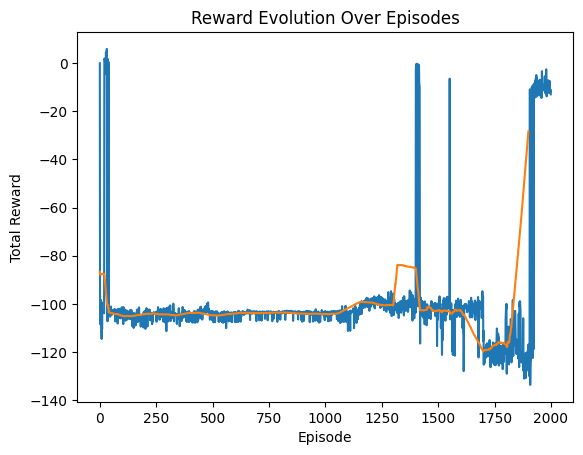

In [25]:

import matplotlib.pyplot as plt

plt.plot(reward_evolution)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
reward_evolution_smoothed = np.convolve(reward_evolution, np.ones(100)/100, mode='valid')
plt.plot(reward_evolution_smoothed)
plt.title('Reward Evolution Over Episodes')
plt.show()

In [ ]:
print(reward_evolution[1:])
path = 'outputs'
filename = '/rewards_multi_ddpg2.txt'
os.makedirs(path, exist_ok=True)
with open(path+filename, 'w') as f:
    f.write(str(reward_evolution[1:]))

[-102.86762261390687, -108.49098149935405, -100.86653198798497, -103.07738614082336, -98.46880059440932, -103.68672597408296, -107.91191826264063, -114.59919102986655, -99.39972883462906, -110.53611594438553, -102.86106198032698, -103.36280326040773, -103.6855507294337, -103.19518317033848, -103.60802926619847, -103.73565934598447, -103.16953744987647, -103.8040135204792, -103.8939878543218, 1.9693263027196077, 1.8409063443541502, 1.57605391399314, 0.7448334608537456, -4.492224037647251, -2.5977505346139322, -2.4600090572300064, 4.466079380673661, 2.9544262563188823, 3.3315209900805103, 3.673096100140048, 5.947968386268864, -96.65806039174397, -101.50700129568577, -107.2607371409734, -103.2272042632103, 1.7188465744256927, -104.07190881483257, -0.28581797145307536, 0.5514894810815629, -102.50062110523383, -103.94267756367724, -101.53131475051245, -102.65261884530386, -102.56310906012853, -104.6189011906584, -105.35083616773288, -102.2879221852248, -102.42280441522598, -101.113286874567

displays 10 iterations of trained agent 

In [24]:
from PIL import Image, ImageDraw
import imageio


# Define function to label the frame with episode number
def _label_with_episode_number(frame, episode_num):
    im = Image.fromarray(frame)
    drawer = ImageDraw.Draw(im)
    text_color = (255, 255, 255) if np.mean(frame) < 128 else (0, 0, 0)
    drawer.text((im.size[0] / 20, im.size[1] / 18), f"Episode: {episode_num+1}", fill=text_color)
    return im

env = multiwalker_v9.parallel_env(render_mode='rgb_array')

frames = []
field_names = ["state", "action", "reward", "next_state", "done"]
memory = ReplayBuffer(memory_size=500, field_names=field_names, action_dim=action_dim[0])
agent = DDPG(state_dim=state_dim, action_dim=action_dim[0], one_hot=one_hot)   # Create DDPG agent
# Load the trained MADDPG model
path = "./models/ONE_DDPG/DDPG5_trained_agent.pt"
DDPG.loadCheckpoint(agent,path=path)
rewards = []

for i in range(10):
    print(i, "th iteration \nrewards mean : ", np.sum(rewards))
    
    state = env.reset()[0]  # Reset environment at start of episode
    state = state['walker_0']
    done = [False]
    rewards = []
    

    while done[0] == False:
        action = agent.getAction(state)[0]    # Get next action from agent
        actions = {agent: action for agent in env.agents}
        next_state, reward, done, _, _ = env.step(actions)   # Act in environment
        if 'walker_0' in next_state.keys():
            next_state = next_state['walker_0']
            done = [True] if done['walker_0'] or done['walker_1'] or done['walker_2'] else [False]
        else :
            next_state = np.empty((31,))
            done = [True]
        reward = reward['walker_0']
        rewards.append(reward)
        # Render and save the frame for video creation
        frame = env.render()  # Now renders an RGB array
        if frame is not None:
            frames.append(_label_with_episode_number(frame, episode_num=i))
        state = next_state

env.close()

# Save frames as an MP4 video
video_path = "./videos/"
os.makedirs(video_path, exist_ok=True)
with imageio.get_writer(os.path.join(video_path, "multiwalker_duplicate1.mp4"), fps=30) as writer:
    for frame in frames:
        writer.append_data(np.array(frame))

0 th iteration 
rewards mean :  0.0
1 th iteration 
rewards mean :  -7.092265129089358
2 th iteration 
rewards mean :  -5.616075932979588
3 th iteration 
rewards mean :  -6.692853212356567
4 th iteration 
rewards mean :  -11.837949732939403
5 th iteration 
rewards mean :  -11.596565822760267
6 th iteration 
rewards mean :  -9.72543001174927
7 th iteration 
rewards mean :  -7.263328462839127
8 th iteration 
rewards mean :  -11.414130886395775
9 th iteration 
rewards mean :  -5.320818205674494


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 400) to (608, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x5b33280] Warning: data is not aligned! This can lead to a speed loss


In [26]:
print(agent.batch_size)

64
